In [1]:
from pyo import *
from jackServer import JackServer
from audioStream import AudioServerManager
# from predictionNetwork import PredictionNetwork
# from VAEnet import VAE
from VAEnetFFT import VAE_FFT
import numpy as np
import multiprocessing
import time

In [4]:
sr = 44100
block_size = 512
channels = 1
init_arr = np.zeros((block_size,))

In [5]:
in_block = multiprocessing.Array('d', init_arr)
out_block = multiprocessing.Array('d', init_arr)
lock = multiprocessing.Lock()

In [11]:
jackManager = JackServer(sr, block_size, 2)
jackManager.system_kill_jack()
jackManager.start_server()

pyoManager = AudioServerManager(sr, block_size, channels)
pyoManager.start_server(in_block, out_block, lock)

None
None
started jack server!

 starting pyo audio server <PyoServer(PyoServer-4, initial daemon)> 

Pyo warning: Jack server started.


In [10]:
VAE_FFT_model = VAE(block_size=block_size,
                in_block=in_block,
                out_block=out_block,
                lock=lock,
                lr=0.005)
VAE_FFT_model.start_thread()


 starting pyo audio server <PyoServer(PyoServer-3, initial daemon)> 

Pyo error: Jack unable to create client.
Pyo error: 
Server not booted.


In [42]:
import tensorflow as tf
import matplotlib.pyplot as plt

test = tf.random.normal([256])
test = tf.cast(test, tf.complex64)
print(test)
print(test.shape)

tf.Tensor(
[ 1.2485979 +0.j  1.0713713 +0.j -0.7496087 +0.j  0.03081485+0.j
 -0.07753457+0.j -0.49837822+0.j  0.20742464+0.j -0.64296174+0.j
 -1.2893231 +0.j -0.25126585+0.j  0.49300942+0.j -0.28524566+0.j
  0.00788567+0.j -0.27652037+0.j -0.6439156 +0.j  0.35954055+0.j
 -0.09213012+0.j -0.53635246+0.j  0.8243892 +0.j -0.37593868+0.j
  0.04988773+0.j  0.507091  +0.j -0.8995568 +0.j  0.98735064+0.j
  0.3480545 +0.j -0.8474287 +0.j  2.3467147 +0.j  0.6493514 +0.j
  0.18580161+0.j -1.0004001 +0.j -1.93077   +0.j -1.935586  +0.j
 -0.7357591 +0.j  1.9785796 +0.j -1.9135802 +0.j -1.3086736 +0.j
 -0.30401272+0.j -0.3631165 +0.j -0.41685385+0.j -0.1530852 +0.j
  0.8577094 +0.j  0.85987836+0.j -0.7730552 +0.j -1.8691709 +0.j
  1.5269887 +0.j -0.5935686 +0.j -0.3833976 +0.j  0.5822671 +0.j
 -1.2876617 +0.j  1.911396  +0.j -0.7571224 +0.j  0.14299671+0.j
 -0.5124875 +0.j -0.0214822 +0.j  1.8017399 +0.j -0.05076249+0.j
  0.88762087+0.j  0.13005622+0.j -0.23200335+0.j  1.1684682 +0.j
  0.7563539 +0

In [43]:
fft = tf.signal.fft(test)
fft = fft[:(len(fft)//2)]
fft = tf.math.abs(fft)
print(fft.shape)

(128,)


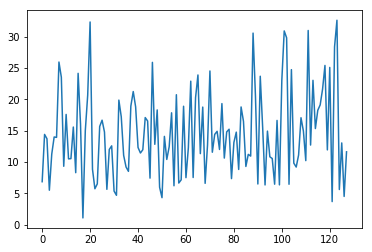

In [44]:
plt.plot(fft)
plt.show()

In [46]:
def fft_to_audio(fft):
    fft = tf.cast(fft, tf.complex64)
    fft = tf.pad(fft, [[0,len(fft)]])
    print(fft.shape)
    audio = tf.signal.ifft(fft)
    audio = tf.cast(audio, tf.float32)
    return audio

audio = fft_to_audio(fft)


(256,)


In [1]:
import time
from watchdog.observers import Observer
from watchdog.events import PatternMatchingEventHandler

In [2]:
patterns = "*"
ignore_patterns = ""
ignore_directories = True
case_sensitive = True
my_event_handler = PatternMatchingEventHandler(patterns, ignore_patterns, ignore_directories, case_sensitive)

In [3]:
def on_created(event):
    print(f"hey, {event.src_path} has been created!")

In [4]:
my_event_handler.on_created = on_created

In [5]:
path = "./tmp/train_blocks/"
my_observer = Observer()
my_observer.schedule(my_event_handler, path, recursive=False)

<ObservedWatch: path=./tmp/train_blocks/, is_recursive=False>

In [6]:
my_observer.start()
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    my_observer.stop()
    my_observer.join()